In [62]:
#%%

import argparse
parser = argparse.ArgumentParser()
parser.add_argument('-O', action='store_true')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import scipy.stats

import gaussparams
import dynamicmodels
import measurementmodels
import estimationstatistics as estats
import ekf
import pda

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
print(f"matplotlib backend: {matplotlib.get_backend()}")
print(f"matplotlib config file: {matplotlib.matplotlib_fname()}")
print(f"matplotlib config dir: {matplotlib.get_configdir()}\n")
plt.close("all")

# set styles
try:
    # gives quite nice plots
    plt_styles = ["science", "grid", "bright", "no-latex"]
    plt.style.use(plt_styles)
    print(f"pyplot using style set {plt_styles}")
except Exception as e:
    print(e)
    print("setting grid and only grid and legend manually")
    plt.rcParams.update(
        {
            # setgrid
            "axes.grid": True,
            "grid.linestyle": ":",
            "grid.color": "k",
            "grid.alpha": 0.5,
            "grid.linewidth": 0.5,
            # Legend
            "legend.frameon": True,
            "legend.framealpha": 1.0,
            "legend.fancybox": True,
            "legend.numpoints": 1,
        }
    )

matplotlib backend: module://ipykernel.pylab.backend_inline
matplotlib config file: c:\users\jeg_j\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\mpl-data\matplotlibrc
matplotlib config dir: C:\SPB_Data\.matplotlib

pyplot using style set ['science', 'grid', 'bright', 'no-latex']


In [65]:
use_pregen = True
data_file_name = "data_for_pda.mat"
if use_pregen:
    loaded_data = scipy.io.loadmat(data_file_name)
    K   = loaded_data["K"].item()
    Ts  = loaded_data["Ts"].item()
    Xgt = loaded_data["Xgt"].T
    Z   = [zk.T for zk in loaded_data["Z"].ravel()]
    true_association = loaded_data["a"].ravel()
else:
    x0 = np.array([0, 0, 1, 1, 0])
    P0 = np.diag([50, 50, 10, 10, pi / 4]) ** 2
    # model parameters
    sigma_a_true = 0.25
    sigma_omega_true = np.pi / 15
    sigma_z = 3
    # sampling interval a length
    K = 1000
    Ts = 0.1
    # detection and false alarm
    PDtrue = 0.9
    lambdatrue = 3e-4
    np.rando.rng(10)
    # [Xgt, Z, a] = sampleCTtrack(K, Ts, x0, P0, qtrue, rtrue,PDtrue, lambdatrue);
    raise NotImplementedError

Text(0.5, 1.0, 'True trajectory and the nearby measurements')

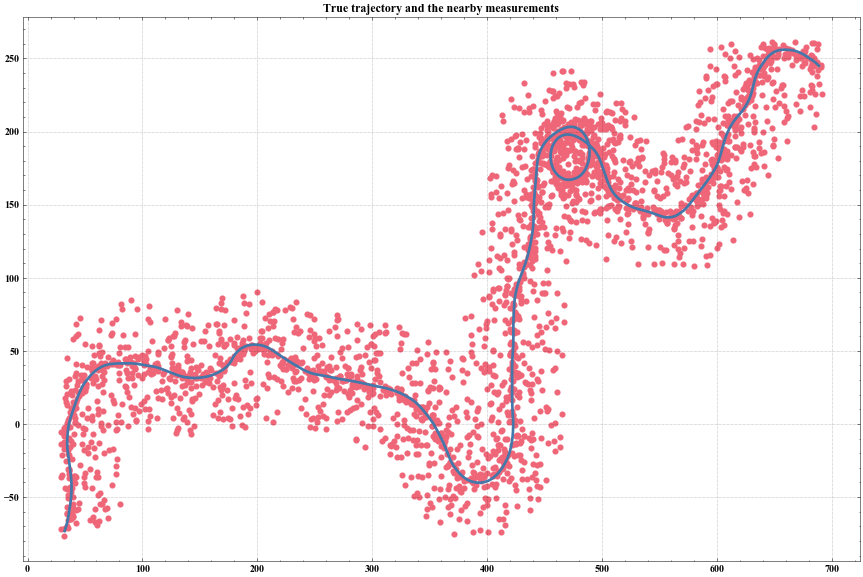

In [66]:
# plot measurements close to the trajectory
fig1, ax1 = plt.subplots(num=1, clear=True, figsize = (15,10))

Z_plot_data = np.empty((0, 2), dtype=float)
plot_measurement_distance = 45
for Zk, xgtk in zip(Z, Xgt):
    to_plot = np.linalg.norm(Zk - xgtk[None:2], axis=1) <= plot_measurement_distance
    Z_plot_data = np.append(Z_plot_data, Zk[to_plot], axis=0)
ax1.scatter(*Z_plot_data.T, color="C1", linewidth=0.1)
ax1.plot(*Xgt.T[:2], color="C0", linewidth=2.7)
ax1.set_title("True trajectory and the nearby measurements")

In [67]:
# Tuning

sigma_a = 2.2
sigma_z = 3.2

PD = 0.8
clutter_intensity = 0.01
gate_size = 5

In [68]:
dynamic_model     = dynamicmodels.WhitenoiseAccelleration(sigma_a)
measurement_model = measurementmodels.CartesianPosition(sigma_z)
ekf_filter        = ekf.EKF(dynamic_model, measurement_model)
tracker           = pda.PDA(ekf_filter, clutter_intensity, PD, gate_size)

# allocate
NEES    = np.zeros(K)
NEESpos = np.zeros(K)
NEESvel = np.zeros(K)

# initialize
x_bar_init = np.array([*Z[0][true_association[0] - 1], 0, 0])

P_bar_init = np.zeros((4, 4))
P_bar_init[[0, 1], [0, 1]] = 2 * sigma_z ** 2
P_bar_init[[2, 3], [2, 3]] = 10 ** 2
init_state = gaussparams.GaussParams(x_bar_init, P_bar_init)
tracker_update       = init_state
tracker_update_list  = []
tracker_predict_list = []

# estimate
for k, (Zk, x_true_k) in enumerate(zip(Z, Xgt)):
    tracker_predict = tracker.predict(init_state, Ts) 
    tracker_update  = tracker.update(Zk, filter_state=tracker_predict) #hva med sensor_state
    updated_state = tracker_update.mean
    updated_cov   = tracker_update.cov
    NEES[k]    = estats.NEES(updated_state, updated_cov, x_true_k, idxs=np.arange(4))
    NEESpos[k] = estats.NEES(updated_state, updated_cov, x_true_k, idxs=np.arange(2))
    NEESvel[k] = estats.NEES(updated_state, updated_cov, x_true_k, idxs=np.arange(2, 4))

    tracker_predict_list.append(tracker_predict)
    tracker_update_list.append(tracker_update)

x_hat = np.array([upd.mean for upd in tracker_update_list])

# calculate a performance metric
posRMSE = np.sqrt(np.mean(np.sum((x_hat[:,:2]-Xgt[:,:2])**2,axis=1)))
velRMSE = np.sqrt(np.mean(np.sum((x_hat[:,2:4]-Xgt[:,2:4])**2,axis=1)))

Text(0.5, 1.0, '$\\sigma_a = 2.200$, $\\sigma_z = 3.200$, $posRMSE = 442.05$, $velRMSE = 11.83$')

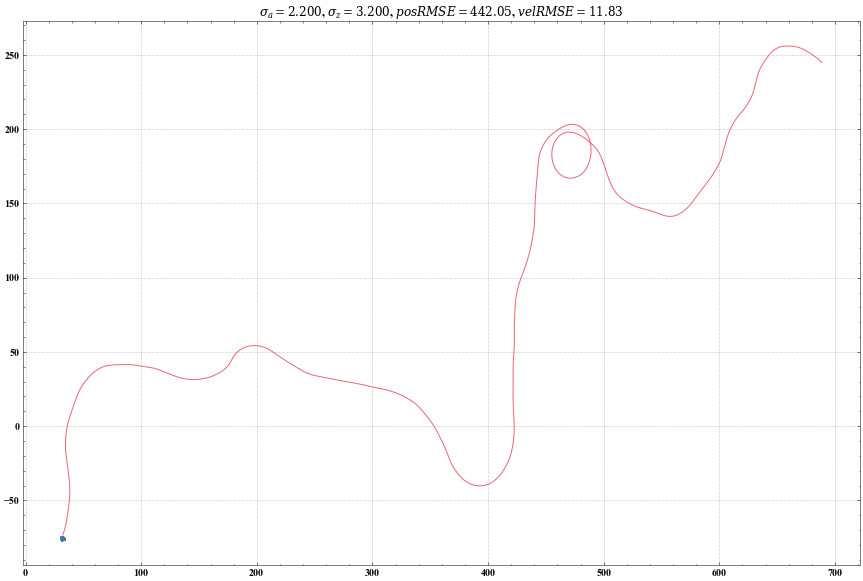

In [69]:
# %% plots
fig3, ax3 = plt.subplots(num=3, clear=True, figsize=(15,10))
ax3.plot(*x_hat.T[:2], label=r"$\hat x$", color="C0",linewidth=2)
ax3.plot(*Xgt.T[:2], label="$x$", color="C1")
ax3.set_title(
    rf"$\sigma_a = {sigma_a:.3f}$, $\sigma_z = {sigma_z:.3f}$, $posRMSE = {posRMSE:.2f}$, $velRMSE = {velRMSE:.2f}$"
)

#fig4, axs4 = plt.subplots(3, sharex=True, num=4, clear=True)